In [35]:
import keras
#from keras import Dense, Sequential, SGD, l2
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
#from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV, KFold
#from keras.wrappers.scikit_learn import KerasRegressor

from sklearn.model_selection import train_test_split
import numpy as np
from numpy import loadtxt
from keras import backend as K

from scikeras.wrappers import KerasRegressor
import time
from sklearn.metrics import make_scorer

from matplotlib import pyplot as plt

In [36]:

'''def read_tr(file_path):
    train = loadtxt(file_path, delimiter=',', usecols=range(1, 14), dtype=np.float64)

    x = train[:, :-3]  # contiene tutte le colonne tranne le ultime tre
    y = train[:, -3:]  # contiene solo le ultime tre colonne (i target).

    return x,y'''
'''def split_data(x,y,test_size=0.15, random_state=42):

# Suddivide il dataset in set di addestramento e test    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state)

    return x_train, y_train, x_test, y_test'''


def read_tr(file_path, test_size=0.15, random_state=42):
    # load tr data
    train = loadtxt(file_path, delimiter=',', usecols=range(1, 14), dtype=np.float64)

    # Esclude la prima colonna e le ultime tre colonne (target)
    x = train[:, :-3]
    y = train[:, -3:]  # Le ultime tre colonne rappresentano i target

    # Suddivide il dataset in set di addestramento e test
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state)

    return x_train, y_train, x_test, y_test


def read_ts():
    file = "./cup/ds/ML-CUP23-TS.csv"
    test = loadtxt(file, delimiter=',', usecols=range(1, 11), dtype=np.float64)

    return test

def euclidean_distance_loss(y_true, y_pred):
    return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))


def create_model(eta=0.001, alpha=0.01, lmb=0.0001, n_units=20, n_layers=3, init_mode='glorot_normal', activation_fx='tanh'):
    model = Sequential()
    
    # create hidden layers
    for i in range (n_layers):
        # dense is for units fully connected 
        model.add(Dense(n_units, kernel_initializer=init_mode, activation=activation_fx, kernel_regularizer=l2(lmb))) 

    # create output layer with 3 neurons for x, y, z
    model.add(Dense(3, activation='linear',kernel_initializer=init_mode))
    
    # use SGD optimizer
    optimizer = SGD(learning_rate=eta, momentum=alpha)
    
    model.compile(optimizer=optimizer, loss=euclidean_distance_loss) 
    return model
    
    
# it retrieves the mean value of all the passed losses
def euclidean_distance_score(y_true, y_pred):
    return np.mean(euclidean_distance_loss(y_true, y_pred))


scorer = make_scorer(euclidean_distance_score, greater_is_better=False)


# split stuff

In [37]:
#file_path = "./cup/ds/ML-CUP23-TR.csv"
#x_train, y_train, x_test, y_test = read_tr(file_path)

# Define a function for model selection: search cool hyperparameters via grid search

In [38]:
def model_selection(x, y, epochs=300):
    
    # reproducibility
    seed = 27
    np.random.seed(seed)

    # create model using a keras regressor, will be used as estimator for the grid search in gridsearchCV
    model = KerasRegressor(build_fn=create_model, epochs=epochs, verbose=0)

    # parameters explored during the grid search, params: learning_rate(eta), momentum(alpha), regularizer(l2), batch_sie
    eta = np.arange(start=0.003, stop=0.01, step=0.001)
    eta = [float(round(i, 4)) for i in list(eta)]

    alpha = np.arange(start=0.4, stop=1, step=0.1)
    alpha = [float(round(i, 1)) for i in list(alpha)]

    lmb = np.arange(start=0.0005, stop=0.001, step=0.0001)
    lmb = [float(round(i, 4)) for i in list(lmb)]

    batch_size = [16, 32, 64]

    param_grid = dict(eta=eta, alpha=alpha, lmb=lmb, batch_size=batch_size)

    start_time = time.time()
    print("Starting the Grid Search...\n")

    # use grid search from scikit lear, passing also as param number of fold of cross-validation
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=10,
                        return_train_score=True, scoring=scorer, verbose=1)

    grid_result = grid.fit(x, y)

    # results, scores of tr e test, traning time, prediction, parameters of each configuration
    print("\nEnded Grid Search. ({:.4f})\n".format(time.time() - start_time))

    means_train = abs(grid_result.cv_results_['mean_train_score'])
    means_test = abs(grid_result.cv_results_['mean_test_score'])
    times_train = grid_result.cv_results_['mean_fit_time']
    times_test = grid_result.cv_results_['mean_score_time']
    params = grid_result.cv_results_['params']

    for m_ts, t_ts, m_tr, t_tr, p in sorted(zip(means_test, times_test, means_train, times_train, params)):
        print("{} \t TR {:.4f} (in {:.4f}) \t TS {:.4f} (in {:.4f})".format(p, m_tr, t_tr, m_ts, t_ts))

    print("\nBest: {:.4f} using {}\n".format(abs(grid.best_score_), grid_result.best_params_))

    best_params = grid_result.best_params_
    best_params['epochs'] = epochs

    return best_params

Predizione sul set di test interno (x_its): Utilizza il modello model per fare previsioni sul set di test interno (x_its) e memorizza i risultati nella variabile y_ipred.

Calcolo della perdita sul set di test interno (y_its, y_ipred): Utilizza la funzione di perdita euclidean_distance_loss per calcolare la perdita tra le previsioni (y_ipred) e i veri valori del set di test interno (y_its). Il risultato viene memorizzato nella variabile iloss.

Predizione sul set di test cieco (x_ts): Utilizza il modello model per fare previsioni sul set di test cieco (x_ts) e memorizza i risultati nella variabile y_pred.

Restituzione dei risultati: Restituisce due valori: le previsioni sul set di test cieco (y_pred) e la perdita sul set di test interno (iloss).

In [39]:
def predict(model, x_ts, x_its, y_its):

    # predict on internal test set
    y_ipred = model.predict(x_its)
    iloss = euclidean_distance_loss(y_its, y_ipred)

    # predict on blind test set
    y_pred = model.predict(x_ts)

    # return predicted target on blind test set,
    # and losses on internal test set
    #return y_pred, K.eval(iloss)
    return [y_pred[:, i] for i in range(y_pred.shape[1])], K.eval(iloss)
#y_pred sarà una matrice in cui ogni colonna rappresenta le previsioni per una delle tre variabili target. 
# La funzione restituirà quindi una lista di array, uno per ciascuna colonna.

In [40]:
def plot_learning_curve(history, start_epoch=1, **kwargs):
    lgd = ['Loss TR']
    plt.plot(range(start_epoch, kwargs['epochs']), history['loss'][start_epoch:])
    
    if "val_loss" in history:
        plt.plot(range(start_epoch, kwargs['epochs']), history['val_loss'][start_epoch:])
        lgd.append('Loss VL')

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f'Keras Learning Curve \n {kwargs}')
    plt.legend(lgd)

    # Check if predictions are available in the history
    if 'predictions' in history:
        predictions = history['predictions']
        
        # Plot predictions for each variable
        for i in range(predictions.shape[1]):
            plt.figure()
            plt.plot(range(start_epoch, kwargs['epochs']), predictions[:, i][start_epoch:])
            plt.xlabel("Epoch")
            plt.ylabel(f"Prediction Variable {i+1}")
            plt.title(f'Keras Learning Curve \n {kwargs} - Prediction Variable {i+1}')
    
    plt.show()


In [41]:
def keras_nn(ms=False):
    print("keras start")

    file_path_tr = "./cup/ds/ML-CUP23-TR.csv"
    # read training set
    x, y, x_its, y_its = read_tr(file_path_tr)

    # choose model selection or hand-given parameters
    if ms:
        params = model_selection(x, y)
    else:
        params = dict(eta=0.002, alpha=0.7, lmb=0.0001, epochs=200, batch_size=64)

    # create and fit the model
    model = create_model(eta=params['eta'], alpha=params['alpha'], lmb=params['lmb'])
    res = model.fit(x, y, validation_split=0.3, epochs=params['epochs'], batch_size=params['batch_size'], verbose=1)

    tr_losses = res.history['loss']
    val_losses = res.history['val_loss']
    
    
  # Predict for the three variables
    y_pred, ts_losses = predict(model=model, x_ts=read_ts(), x_its=x_its, y_its=y_its)

    print("TR Loss: ", tr_losses[-1])
    print("VL Loss: ", val_losses[-1])
    print("TS Loss: ", np.mean(ts_losses))

# Extract predictions for each variable
    y_pred_x, y_pred_y, y_pred_z = y_pred

    print("Predictions for X: ", y_pred_x)  
    print("Predictions for Y: ", y_pred_y)
    print("Predictions for Z: ", y_pred_z)

    print("keras end")

    plot_learning_curve(res.history, savefig=True, **params)
    

keras start
Epoch 1/200


10/10 [==============================] - 0s 14ms/step - loss: 42.9082 - val_loss: 42.8134
Epoch 2/200
10/10 [==============================] - 0s 3ms/step - loss: 42.5017 - val_loss: 42.3729
Epoch 3/200
10/10 [==============================] - 0s 3ms/step - loss: 42.0916 - val_loss: 41.9738
Epoch 4/200
10/10 [==============================] - 0s 3ms/step - loss: 41.7222 - val_loss: 41.6179
Epoch 5/200
10/10 [==============================] - 0s 3ms/step - loss: 41.3895 - val_loss: 41.2974
Epoch 6/200
10/10 [==============================] - 0s 3ms/step - loss: 41.0913 - val_loss: 41.0041
Epoch 7/200
10/10 [==============================] - 0s 3ms/step - loss: 40.8154 - val_loss: 40.7328
Epoch 8/200
10/10 [==============================] - 0s 3ms/step - loss: 40.5575 - val_loss: 40.4740
Epoch 9/200
10/10 [==============================] - 0s 3ms/step - loss: 40.3127 - val_loss: 40.2286
Epoch 10/200
10/10 [==============================] - 0s 3ms/step - loss: 40.0772 - val_loss: 39.9885


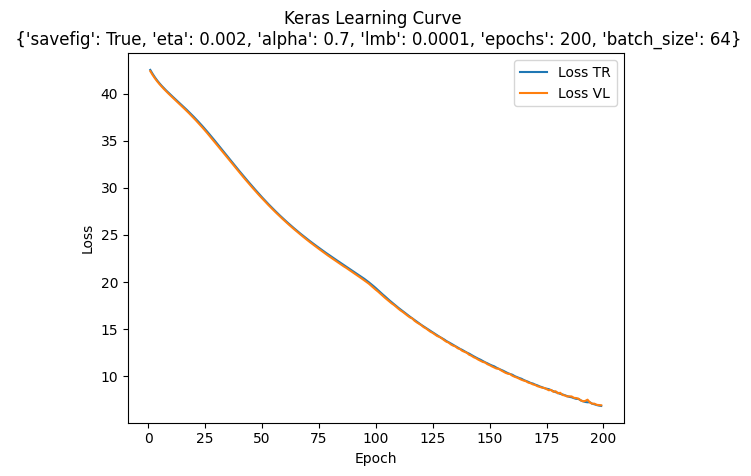

In [42]:
keras_nn()